In [1]:
from quantum_electron import FullModel, QuantumAnalysis, PotentialVisualization, package_versions
import numpy as np
from matplotlib import pyplot as plt
from scipy.constants import elementary_charge as qe, epsilon_0 as eps0, electron_mass as me

package_versions()

quantum_electron 0.2.2
numpy 1.25.2
scipy 1.9.3
matplotlib 3.5.3


# Construct a harmonic potential

We're going to create a potential landscape generated by a single circular electrode of radius $R$. We'll call this electrode the `dot` electrode.
Around the `dot` electrode there is a guard ring, called the `gnd` electrode. We'll first construct the potential landscape and then show the basic functionality of the modules. Let's get started:

In [2]:
# Note that the units of x and y are implicitly assumed as microns
x = np.linspace(-2, 2, 201)
y = np.linspace(-2, 2, 201)

micron = 1e-6

X, Y = np.meshgrid(x, y)
X *= micron
Y *= micron

parabolic_confinement = - (X ** 2 + Y ** 2) / micron ** 2

R = 2e-6
# outside the circle there is a guard ring where the dot 
parabolic_confinement[np.sqrt(X**2 + Y**2) > R] = -(R / micron) ** 2
# parabolic_confinement -= -(R / micron) ** 2

# also add the guard ring
guard_ring = np.ones(X.shape)
guard_ring[np.sqrt(X**2 + Y**2) < R] = 0 

The `potential_dict` dictionary contains the coupling constants for each electrode. These are the values of the potential energy as if 1V was applied to the electrode. There are no restrictions on the number of electrodes in this dictionary. For example, we added an explicit ground electrode `gnd`. This allows us to play around with the ground potential if we wanted to do so. 

The only restrictions on `potential_dict` are that the dictionary must contain `xlist` and `ylist`. 

The dictionary `voltages` dictates what voltages are applied to each electrode with the appropriate key.

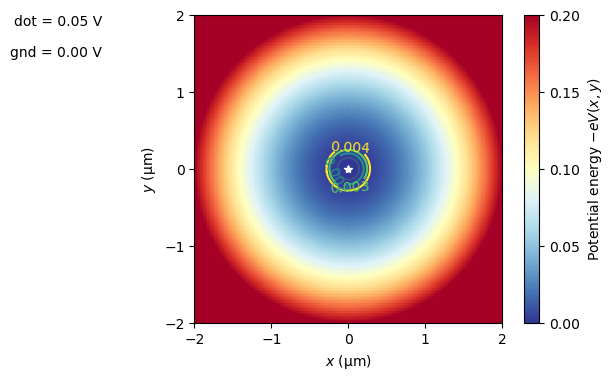

In [3]:
potential_dict = {"dot" : parabolic_confinement, 
                  "gnd" : guard_ring, 
                  "xlist" : x, 
                  "ylist" : y}

# Let's apply these voltages to the corresponding electrodes in potential_dict
voltages = {"dot" : 0.05, 
            "gnd" : 0}

p = PotentialVisualization(potential_dict, voltages)
p.plot_potential_energy(dxdy=(4, 4))

At this point you should be familiar with the input type for the functions in `quantum_electron`. You can now load your own potential data and create your own version of `potential_dict` and `voltages`. 

# Adding your first electrons 

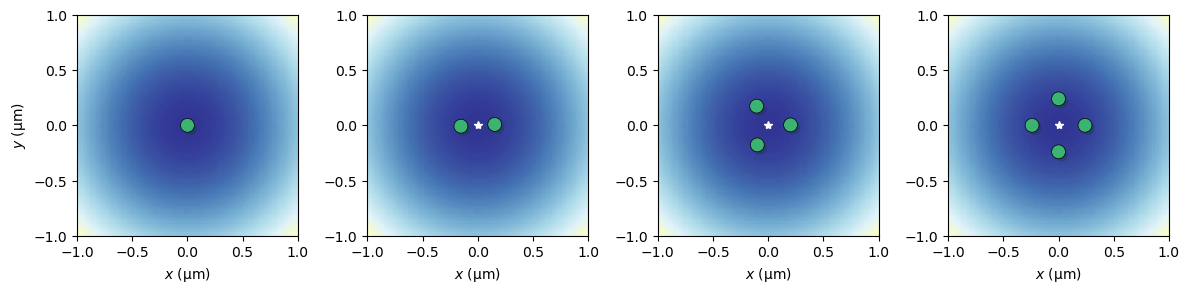

In [4]:
n_electrons = 4
fig, ax = plt.subplots(1, n_electrons, figsize=(12, 6))

for k in range(n_electrons):
    fm = FullModel(potential_dict=potential_dict, voltage_dict=voltages)
    res = fm.get_electron_positions(n_electrons=k+1, electron_initial_positions=None)

    fm.plot_potential_energy(ax=ax[k], dxdy=(2, 2), print_voltages=False, plot_contours=False)
    fm.plot_electron_positions(res, ax=ax[k])

    if k > 0:
        ax[k].set_ylabel("")

fig.tight_layout()

To make sure the code is working properly, we can compare the expected positions with theory. You can derive these expressions directly from the force balance: the Coulomb interaction should balance the confinement.

You can also check the theory values in this paper: https://journals.aps.org/prb/abstract/10.1103/PhysRevB.51.7700  or the author's thesis https://schusterlab.stanford.edu/static/pdfs/Koolstra_thesis.pdf (pg. 118)

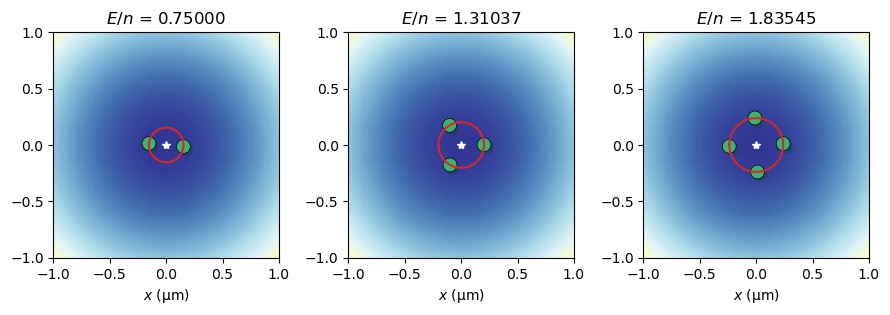

In [5]:
# The confinement parameter is the curvature of the dot near the origin
alpha = 1 / (micron) ** 2 * voltages['dot'] * qe
r0 = (qe ** 2 / (4 * np.pi * eps0 * alpha)) ** (1/3)
E0 = (alpha * qe ** 4 / (4 * np.pi * eps0) ** 2) ** (1/3)

# These are the values for the radius one would expect from theory for n = 2, 3, 4 electrons
theory = [r0 / 2, r0 / (2 * np.sqrt(3)) ** (1/3), 0.78 * r0]

# Let's plot these predictions on top of the simulation:
n_electrons = [2, 3, 4]
fig, ax = plt.subplots(1, len(n_electrons), figsize=(9, 6))

for k, n in enumerate(n_electrons):
    fm = FullModel(potential_dict=potential_dict, voltage_dict=voltages)
    res = fm.get_electron_positions(n_electrons=n, electron_initial_positions=None)

    fm.plot_potential_energy(ax=ax[k], dxdy=(2, 2), print_voltages=False, plot_contours=False)
    fm.plot_electron_positions(res, ax=ax[k])

    theta = np.linspace(-np.pi, np.pi)
    ax[k].plot(theory[k] / micron * np.cos(theta), theory[k] / micron * np.sin(theta), color='tab:red')

    ax[k].set_title(fr"$E/n$ = {res['fun'] * qe / (n * E0):.5f}")

    if k >= 0:
        ax[k].set_ylabel("")

fig.tight_layout()

We see the agreement between the simulation is great.

# Magic numbers

For a certain electron numbers there are metastable states, see https://journals.aps.org/prb/abstract/10.1103/PhysRevB.51.7700. Let's take a look at some of these configurations and make sure that the code predicts the correct ground states. 
We will denote the occupation in rings, where the inner-most ring is listed first.

Theory prediction for $n = 5$
- Ground state: (5)
- Excited state: (1, 4)

Theory prediction for $n = 6$
- Ground state: (1, 5)
- Excited state: (6)

Theory prediction for $n = 9$
- Ground state: (2, 7)
- Excited state: (1, 8)

Theory prediction for $n=15$:
- Ground state: (5, 10)
- Excited state: (6, 9)

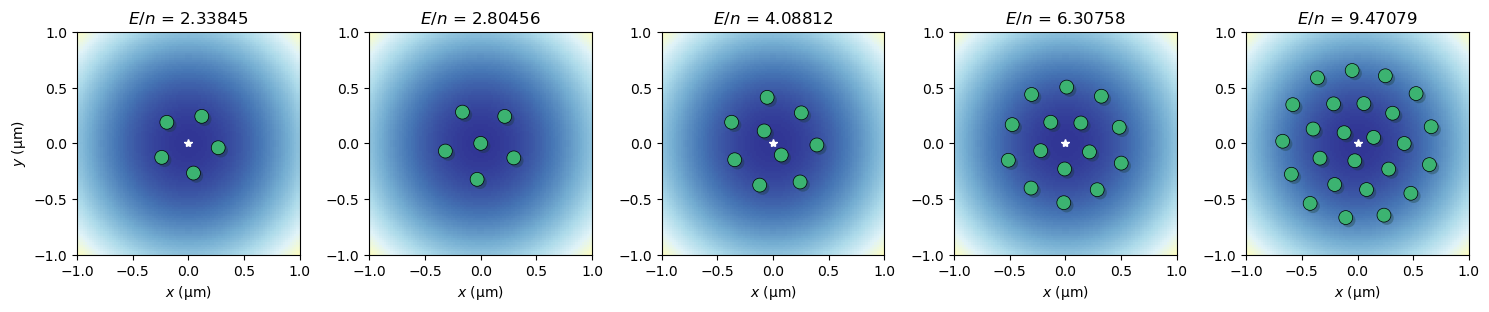

In [6]:
# Let's plot these predictions on top of the simulation:
n_electrons = [5, 6, 9, 15, 25]
fig, ax = plt.subplots(1, len(n_electrons), figsize=(len(n_electrons) * 3, 6))

for k, n in enumerate(n_electrons):
    fm = FullModel(potential_dict=potential_dict, voltage_dict=voltages, trap_annealing_steps=[4.0]*10)
    res = fm.get_electron_positions(n_electrons=n, electron_initial_positions=None)

    fm.plot_potential_energy(ax=ax[k], dxdy=(2, 2), print_voltages=False, plot_contours=False)
    fm.plot_electron_positions(res, ax=ax[k])

    ax[k].set_title(fr"$E/n$ = {np.round(res['fun'] * qe / (n * E0), 5):.5f}")

    if k >= 1: 
        ax[k].set_ylabel("")

fig.tight_layout()

Note that we added a slightly higher annealing temperature of 4K to arrive at the ground state for $n = 6$

# Visualizing eigenmodes

The motional states of these molecules can easily be calculated using `quantum_electron`. The results can be compared with the theory work in https://journals.aps.org/prb/abstract/10.1103/PhysRevB.51.7700. In this work, the units are in natural frequency $\omega_0 / \sqrt{2}$, where $\omega_0$ is defined via the potential energy $U = \frac{1}{2} m_e \omega_0 ^ 2$. We will show the dimensionless frequency of the simulated modes in the titles for easy comparison.

Please note that there are at most $2n + 1$ eigenmodes. The first eigenmode is typically the resonator, which we may ignore for now. 

In [7]:
trap_curvature = np.sqrt(1 / (micron) ** 2 * voltages['dot'] * qe * 2 / me)
natural_frequency = trap_curvature/(2 * np.pi * np.sqrt(2))

Because the equations of motion consider electrons coupled to a resonator, we must supply the resonance frequency of the resonator and the impedance to `setup_eom`. If not interested in the cavity, or if you simply want to study the plasmons in the absence of the resonator, you can set the resonance frequency far off-resonant.

In [8]:
resonator_dict = {"f0" : 100e6, 
                  "Z0" : 50}

/Users/gerwinkoolstra/Documents/Code/quantum_electron/quantum_electron/eom_solver.py:383: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(EVals) / (2 * np.pi), EVecs


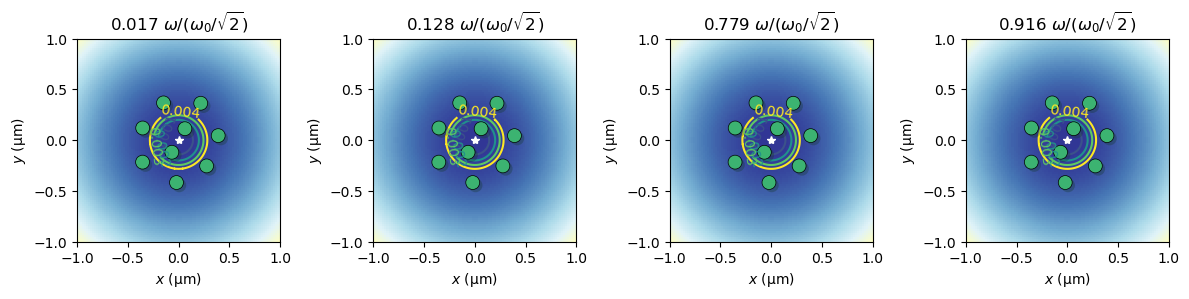

In [9]:
mode_idcs = range(1, 5)
n_electrons = 9

fig, ax = plt.subplots(1, len(mode_idcs), figsize=(len(mode_idcs) * 3, 6))

for k, m in enumerate(mode_idcs):
    fm = FullModel(potential_dict=potential_dict, voltage_dict=voltages, trap_annealing_steps=[1.0]*10)
    res = fm.get_electron_positions(n_electrons=n_electrons, electron_initial_positions=None)
    fm.set_rf_interpolator(rf_electrode_labels=['dot', 'gnd'])

    fm.plot_potential_energy(ax=ax[k], dxdy=(2, 2), print_voltages=False, plot_contours=True)

    K, M = fm.setup_eom(res['x'], resonator_dict=resonator_dict)
    efreqs, evecs = fm.solve_eom(K, M, sort_by_cavity_participation=False)

    ax[k].set_title(f"{efreqs[m]/natural_frequency:.3f} "+r"$\omega / (\omega_0/\sqrt{2})$")

fig.tight_layout()
anim = fm.animate_eigenvectors(fig, ax, evecs.T, res['x'], amplitude=0.5e-7)

In [10]:
fm.show_animation(anim)

Text(0, 0.5, '$\\sqrt{2}\\omega / \\omega_0$')

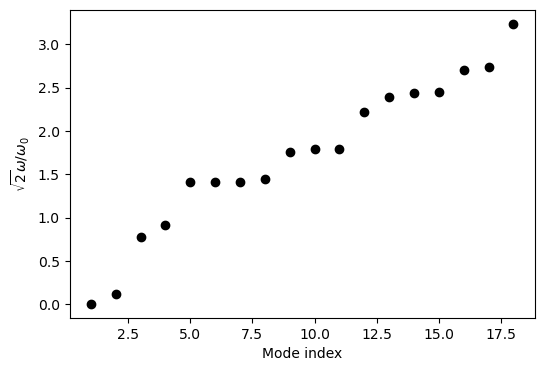

In [11]:
plt.figure(figsize=(6., 4.))
plt.plot(efreqs / natural_frequency, 'ok')
plt.xlabel("Mode index")
plt.ylabel(r"$\sqrt{2}\omega / \omega_0$")